### Importing Requried libraries

In [1]:
import networkx as nx
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import sys

### Import Dataset

In [2]:
FielName='C:/Users/PURUSHOTHAM REDDY/Desktop/CollegeMsg.txt'

### Building network data

In [3]:
Graphtype=nx.DiGraph()
G = nx.read_edgelist(FielName, create_using=Graphtype, nodetype=int, data=(('weight',float),))

### Coverted into undirected graph type

In [4]:
g = G.to_undirected()
print(nx.info(g))


Name: 
Type: Graph
Number of nodes: 1899
Number of edges: 13838
Average degree:  14.5740


### Sample graph data and its edges 

C:\Users\PURUSHOTHAM REDDY\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


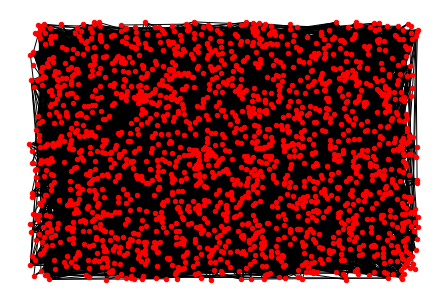

In [5]:
nx.draw_random(g, with_labels=False, node_size=20, node_color='r')

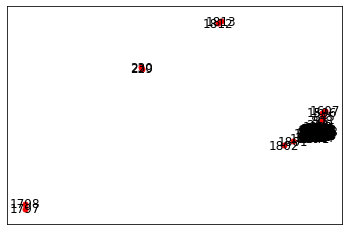

In [6]:
nx.draw_networkx(g, with_labels=True, node_size=25, node_color='r')
plt.show()

### Preprocessing
gae is a lib used to divide network dataset into traning and test 
test_edges= This contains randon positive edges of given %
test_edges_false= This contains false edges which is done manual using this library 

In [7]:
from gae.preprocessing import mask_test_edges
np.random.seed(0)
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Performing train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.4, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) 

In [8]:
print ("Total nodes:", adj_sparse.shape[0])
print ("Total edges:", int(adj_sparse.nnz/2))
#print ("Training nodes (positive):", adj_train.shape[0])
#print ("Training edges total edges:", int(adj_train.nnz/2))
#print ("Test edges (positive):", len(test_edges))
#print ("Test edges (negative):", len(test_edges_false))

Total nodes: 1899
Total edges: 13838


### Function for metrics calulation
Implemented ROC_AUC score and precision 

In [9]:
def get_roc_score(edges_pos, edges_neg, score_matrix):#test edges and test edges false
    # Stores positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Stores negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculates scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

### 1. Jaccard coefficient of nodes u and v is defined as

<img src = "img/2.png.png" width = 200  height=200>
where Γ(u)
denotes the set of neighbors of u.

### Top k future links from JC 

In [10]:
preds = nx.jaccard_coefficient(g)
lst = list(preds)
def takethird(elem):
    return elem[2]
lst.sort(key = takethird,reverse = True)


In [11]:
print(lst[0:10])

[(4, 618, 1.0), (4, 1609, 1.0), (4, 1711, 1.0), (4, 1751, 1.0), (4, 1784, 1.0), (4, 1795, 1.0), (11, 165, 1.0), (16, 24, 1.0), (16, 49, 1.0), (16, 150, 1.0)]


In [12]:
# Jaccard Coefficients 
adj=nx.to_numpy_array(g)
jc_matrix = np.zeros(adj.shape)
for u, v, p in nx.jaccard_coefficient(g_train): 
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p 
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()
print(jc_matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.01041667 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01041667 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [13]:
# ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print ('Jaccard Coefficient Test ROC score: ', str(jc_roc))
print ('Jaccard Coefficient Test AP score: ', str(jc_ap))

Jaccard Coefficient Test ROC score:  0.6513793230073222
Jaccard Coefficient Test AP score:  0.592906196338169


### 2. Preferential attachment score of u and v is defined as

<img src = "img/3.png.png" width = 200  height=200>
where Γ(u)
denotes the set of neighbors of u.

In [14]:
pa_matrix = np.zeros(adj.shape)
for u, v, p in nx.preferential_attachment(g_train): 
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p 
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()

In [15]:
# ROC AUC and Average Precision
pa_roc, pa_ap= get_roc_score(test_edges, test_edges_false, pa_matrix)

print ('Preferential Attachment Test ROC score: ', str(pa_roc))
print ('Preferential Attachment Test AP score: ', str(pa_ap))

Preferential Attachment Test ROC score:  0.9177154332820051
Preferential Attachment Test AP score:  0.9109426214220981


### Top k links of preferential_attachment

In [16]:
predsP = nx.preferential_attachment(g)
lstP = list(predsP)
def takethird(elem):
    return elem[2]
lstP.sort(key = takethird, reverse = True)


In [17]:
print(lstP[0:10])

[(9, 103, 61455), (103, 105, 57885), (103, 400, 57885), (9, 400, 54707), (32, 103, 52785), (105, 400, 51529), (41, 103, 46665), (3, 103, 45390), (42, 103, 45135), (9, 41, 44103)]


### 3.Resource allocation index of u and v is defined as

<img src = "img/4.png.png" width = 200  height=200>

where Γ(u)
denotes the set of neighbors of u.

In [18]:
ra_matrix = np.zeros(adj.shape)
for u, v, p in nx.resource_allocation_index(g_train): 
    ra_matrix[u][v] = p
    ra_matrix[v][u] = p 
    
# Normalize array
ra_matrix = ra_matrix / ra_matrix.max()

In [19]:
print(ra_matrix)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.0133815 0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.0133815 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


In [20]:
ra_roc, ra_ap= get_roc_score(test_edges, test_edges_false, ra_matrix)

print ('resource_allocation_index Test ROC score: ', str(ra_roc))
print ('resource_allocation_index Test AP score: ', str(ra_ap))

resource_allocation_index Test ROC score:  0.6637716461476569
resource_allocation_index Test AP score:  0.6629058231985816


### Top k links of resource_allocation_index

In [21]:
predsRA = nx.resource_allocation_index(g)
lstRA = list(predsRA)
def takethird(elem):
    return elem[2]
lstRA.sort(key = takethird,reverse = True)

In [22]:
print(lstRA[0:10])

[(103, 400, 6.7263103855834165), (41, 400, 5.7725606144702475), (9, 400, 4.976091273797194), (9, 41, 4.695896387239228), (9, 103, 4.06771848231153), (41, 103, 3.758206560622722), (19, 400, 3.485116017741492), (9, 1539, 3.297341547659721), (103, 357, 3.296704440499052), (19, 103, 3.119387511216108)]



### 4.Adamic-Adar index of u and v is defined as

<img src = "img/1.png" width = 200  height=200>

where Γ(u)
denotes the set of neighbors of u.

In [23]:
adj=nx.to_numpy_array(g)
aa_matrix = np.zeros(adj.shape)
for u, v, p in nx.adamic_adar_index(g_train): 
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p 
    
# Normalize
aa_matrix = aa_matrix / aa_matrix.max()

In [24]:
print(aa_matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02494421 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02494421 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [25]:
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print ('Adamic-Adar Test ROC score: ', str(aa_roc))
print ('Adamic-Adar Test AP score: ', str(aa_ap))

Adamic-Adar Test ROC score:  0.6638228763498112
Adamic-Adar Test AP score:  0.6647854459741445


### Top k links of Adamic-Adar

In [26]:
predsAA = nx.adamic_adar_index(g)
lstAA = list(predsAA)
def takethird(elem):
    return elem[2]
lstAA.sort(key = takethird,reverse = True)

In [27]:
print(lstAA[0:10])

[(103, 400, 38.302174833350236), (9, 103, 26.70208864657891), (41, 400, 26.128483966730343), (9, 400, 26.011431176325402), (103, 357, 23.450833729015024), (41, 103, 23.06009177618845), (9, 41, 21.962608050403748), (103, 249, 21.226303269324582), (357, 400, 19.48657322598024), (103, 176, 18.869428685409197)]


C:\Users\PURUSHOTHAM REDDY\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<function matplotlib.pyplot.draw()>

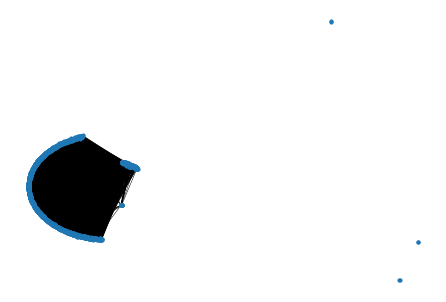

In [28]:
nx.draw_kamada_kawai(g,node_size=10,arrowsize=4, width=0.5)
plt.draw